<a href="https://colab.research.google.com/github/Andrew-Fryer/signet-pytorch/blob/master/ELEC_874_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I'm building off of this: https://github.com/VinhLoiIT/signet-pytorch

In [4]:
import sys
print(sys.version)

import os
import numpy as np
import pandas as pd
import itertools
import glob
from PIL import Image, ImageOps
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import datetime

from torch.utils.data import Dataset, DataLoader

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


In [5]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = 'drive/MyDrive/Colab Data/'
sig_data_dir = data_dir + 'cedar_signatures/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
def get_files(csv_file: str):
  df = pd.read_csv(csv_file, header=None)
  files = set()
  for i in range(len(df)):
    x1, x2, y = df.iloc[i]
    files.add(x1)
    files.add(x2)
  return list(files)

class ImgDataset(Dataset):
  def __init__(self, files, image_transform):
    self.files = files
    self.image_transform = image_transform
  def __len__(self):
    return len(self.files)
  def __getitem__(self, index):
    x = self.files[index]
    # hack off the "data/CEDAR/" and add on sig_data_dir
    x = sig_data_dir + x[11:]
    # x = torchvision.io.read_image(x)
    x = Image.open(x).convert('L')
    x = self.image_transform(x)
    return x

no_norm_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((155, 220)),
    ImageOps.invert,
    torchvision.transforms.ToTensor(),
])
files = get_files(sig_data_dir + "train.csv")
print('num files:', len(files))
train_image_set = ImgDataset(files, no_norm_transform)

imgs = torch.stack([item[0] for item in train_image_set], dim=0).numpy()

num files: 2400


KeyboardInterrupt: ignored

In [12]:
imgs.shape

(2400, 155, 220)

In [13]:
mean = imgs[:, :, :].mean()

In [14]:
std_dev = imgs[:, :, :].std()

In [15]:
print('mean, std', mean, std_dev)

mean, std 0.05041306 0.07968917


In [19]:
files += get_files(sig_data_dir + "test.csv")
print('num files:', len(files))

image_transform = torchvision.transforms.Compose([
    # "We resize all the images to a fixed size 155×220 using bilinear interpolation."
    torchvision.transforms.Resize((155, 220)), # Default is InterpolationMode.BILINEAR
    # "Afterwards, we invert the images so that the background pixels have 0 values."
    ImageOps.invert,
    torchvision.transforms.ToTensor(),
    # "Furthermore, we normalize each image by dividing the pixel values with the standard deviation of the pixel values of the images in a dataset."
    # I'm (Andrew) assuming that we subtract the mean first...
    torchvision.transforms.Normalize(mean, std_dev),
])
image_set = list(ImgDataset(files, image_transform))
file_dict = {}
for i in range(len(files)):
  file_dict[files[i]] = i

torch.save(image_set, sig_data_dir + 'image_set.pt')
torch.save(file_dict, sig_data_dir + 'file_dict.pt')

num files: 2880


In [ ]:
# create data sets
'''
The files are stored in 2 directories.
One contains genuine signatres.
The other contains forgeries.
Then, there are csv files which store file names.
'''

seed = 2020
np.random.seed(seed)
batch_size = 8 # 32
learning_rate = 1e-5

class SignDataset(Dataset):
    def __init__(self, csv_file: str, image_transform=None):
        self.df = pd.read_csv(csv_file, header=None)
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        x1, x2, y = self.df.iloc[index]

        # hack off the "data/CEDAR/" and add on sig_data_dir
        x1 = sig_data_dir + x1[11:]
        x2 = sig_data_dir + x2[11:]

        x1 = Image.open(x1).convert('L')
        x2 = Image.open(x2).convert('L')
        
        if self.image_transform:
            x1 = self.image_transform(x1)
            x2 = self.image_transform(x2)

        return x1, x2, y

image_transform = torchvision.transforms.Compose([
    # "We resize all the images to a fixed size 155×220 using bilinear interpolation."
    torchvision.transforms.Resize((155, 220)), # Default is InterpolationMode.BILINEAR
    # "Afterwards, we invert the images so that the background pixels have 0 values."
    ImageOps.invert,
    torchvision.transforms.ToTensor(),
    # "Furthermore, we normalize each image by dividing the pixel values with the standard deviation of the pixel values of the images in a dataset."
    # I'm (Andrew) assuming that we subtract the mean first...
    torchvision.transforms.Normalize(mean, std_dev),
])

train_set = SignDataset(sig_data_dir + "train.csv", image_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
val_set = SignDataset(sig_data_dir + "test.csv", image_transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True)


In [4]:
x1s, x2s, labels = next(iter(val_loader))

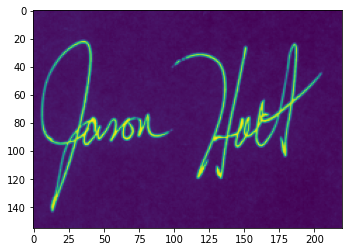

In [5]:
img = train_set[0][0][0].numpy()
plt.imshow(img)
plt.show()

In [6]:
class SigNet(nn.Module):
    '''
    Reference Keras: https://github.com/sounakdey/SigNet/blob/master/SigNet_v1.py
    '''
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            #input size = [155, 220, 1]
            nn.Conv2d(1, 96, 11), # size = [145,210]
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(2, stride=2), # size = [72, 105]
            nn.Conv2d(96, 256, 5, padding=2, padding_mode='zeros'), # size = [72, 105]
            nn.LocalResponseNorm(size=5, k=2, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(2, stride=2), # size = [36, 52]
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, 3, stride=1, padding=1, padding_mode='zeros'),
            nn.Conv2d(384, 256, 3, stride=1, padding=1, padding_mode='zeros'),
            nn.MaxPool2d(2, stride=2), # size = [18, 26]
            nn.Dropout2d(p=0.3),
            nn.Flatten(1, -1), # 18*26*256
            nn.Linear(18*26*256, 1024),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 256),
        )

        # TODO: init bias = 0

    def forward(self, x1, x2):
        x1 = self.features(x1)
        x2 = self.features(x2)
        return x1, x2

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, alpha, beta, margin):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.margin = margin

    def forward(self, x1, x2, y):
        '''
        Shapes:
        -------
        x1: [B,C]
        x2: [B,C]
        y: [B,1]

        Returns:
        --------
        loss: [B,1]]
        '''
        distance = torch.pairwise_distance(x1, x2, p=2)
        loss = self.alpha * (1-y) * distance**2 + \
               self.beta * y * (torch.max(torch.zeros_like(distance), self.margin - distance)**2)
        return torch.mean(loss, dtype=torch.float)

In [8]:
seed = 2020
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

Device: cpu


In [9]:
def train(model, optimizer, criterion, dataloader, log_interval=50):
    model.train()
    running_loss = 0
    number_samples = 0

    for batch_idx, (x1, x2, y) in enumerate(dataloader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)

        optimizer.zero_grad()
        x1, x2 = model(x1, x2)
        loss = criterion(x1, x2, y)
        loss.backward()
        optimizer.step()

        number_samples += len(x1)
        running_loss += loss.item() * len(x1)
        if (batch_idx + 1) % log_interval == 0 or batch_idx == len(dataloader) - 1:
            print('{}/{}: Loss: {:.4f}'.format(batch_idx+1, len(dataloader), running_loss / number_samples))
            running_loss = 0
            number_samples = 0

def accuracy(distances, y, step=0.01):
    min_threshold_d = min(distances)
    max_threshold_d = max(distances)
    max_acc = 0
    same_id = (y == 1)

    for threshold_d in torch.arange(min_threshold_d, max_threshold_d+step, step):
        true_positive = (distances <= threshold_d) & (same_id)
        true_positive_rate = true_positive.sum().float() / same_id.sum().float()
        true_negative = (distances > threshold_d) & (~same_id)
        true_negative_rate = true_negative.sum().float() / (~same_id).sum().float()

        acc = 0.5 * (true_negative_rate + true_positive_rate)
        max_acc = max(max_acc, acc)
    return max_acc

@torch.no_grad()
def eval(model, criterion, dataloader, log_interval=50):
    model.eval()
    running_loss = 0
    number_samples = 0

    distances = []

    for batch_idx, (x1, x2, y) in enumerate(dataloader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)

        x1, x2 = model(x1, x2)
        loss = criterion(x1, x2, y)
        distances.extend(zip(torch.pairwise_distance(x1, x2, 2).cpu().tolist(), y.cpu().tolist()))

        number_samples += len(x1)
        running_loss += loss.item() * len(x1)

        if (batch_idx + 1) % log_interval == 0 or batch_idx == len(dataloader) - 1:
            print('{}/{}: Loss: {:.4f}'.format(batch_idx+1, len(dataloader), running_loss / number_samples))

    distances, y = zip(*distances)
    distances, y = torch.tensor(distances), torch.tensor(y)
    max_accuracy = accuracy(distances, y)
    print(f'Max accuracy: {max_accuracy}')
    return running_loss / number_samples, max_accuracy

In [10]:
def do_training():
    model = SigNet().to(device)
    criterion = ContrastiveLoss(alpha=1, beta=1, margin=1).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=5e-4, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 5, 0.1)
    num_epochs = 20

    model.train()
    print(model)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('Training', '-'*20)
        train(model, optimizer, criterion, train_loader)
        print('Evaluating', '-'*20)
        loss, acc = eval(model, criterion, val_loader)
        scheduler.step()

        to_save = {
            'model': model.state_dict(),
            'scheduler': scheduler.state_dict(),
            'optim': optimizer.state_dict(),
        }

        print('Saving checkpoint..')
        torch.save(to_save, sig_data_dir + 'epoch_{}_loss_{:.3f}_acc_{:.3f}.pt'.format(epoch, loss, acc))

    print('Done')

In [ ]:
do_training()

SigNet(
  (features): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.3, inplace=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.3, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=119808, out_features=1024, bias=True)
    (14): Dropout2d(p=0.5, inplace=False)
    (15): Linear(in_features=1024, out_features=256,